# Training Set

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
%matplotlib inline

### Read raw training data

In [2]:
amazon = pd.read_csv('/Users/Aaron_hill/Dropbox/data/ml_19/amazon_data/raw_data_train.csv')
print(amazon.shape)

(364000, 14)


In [3]:
print(amazon.head())
print(amazon['helpful'].mean())

   Unnamed: 0  Unnamed: 0.1      Id   ProductId          UserId  \
0      411691         18077   18078  B008ZRKZSM  A1F46LDQHEG0II   
1      129031         55240   55241  B00110C04M   A9E4DT8PPC33A   
2      381650        499749  499750  B000VVTTPA  A174BBGE21P9NL   
3      444366         78296   78297  B0069AA4Q0  A1D847PJXKDCVF   
4      190015        535270  535271  B0000ZSH8M   A4OOLWKWQR3UZ   

       ProfileName  HelpfulnessNumerator  HelpfulnessDenominator  Score  \
0         Vulpes13                     0                       0      5   
1      Joan Bailey                     0                       0      5   
2         C. Burns                     3                       3      5   
3  Long Island MOM                     2                      12      1   
4             Lana                     4                       4      5   

         Time                                 Summary  \
0  1336608000                           Really great!   
1  1240531200                   

### Feature extraction on natural language data

In [4]:
# # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer()
# corpus = amazon.Text.as_matrix()
# X_bag_of_words = vectorizer.fit_transform(corpus)
# print(X_bag_of_words.toarray())

In [5]:
# vectorize Bag of Words from review text; as sparse matrix
from sklearn.feature_extraction.text import HashingVectorizer
hv = HashingVectorizer(n_features=2 ** 17, non_negative=True)
X_hv = hv.fit_transform(amazon.Text)
print(X_hv.shape)

/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


(364000, 131072)


In [6]:
type(X_hv)

scipy.sparse.csr.csr_matrix

In [7]:
# We want to be able to use this model fit on other data (the test set)
# So let's save a copy of this instance of HashingVectorizer to be able to transform other data with this fit
# http://scikit-learn.org/stable/modules/model_persistence.html
joblib.dump(hv, 'hv.pkl') # pickle

['hv.pkl']

In [8]:
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
X_tfidf = transformer.fit_transform(X_hv)

joblib.dump(transformer, 'transformer.pkl') # pickle

['transformer.pkl']

In [9]:
print(type(X_tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


### Create additional quantitative features

In [10]:
# features from Amazon.csv to add to feature set
amazon['reviewLen'] = amazon['Text'].str.len()

X_quant_features = amazon[["Score", "reviewLen"]]
print(X_quant_features.head(10))
print(type(X_quant_features))

   Score  reviewLen
0      5        615
1      5        197
2      5       1013
3      1        158
4      5        115
5      5        723
6      5        371
7      5        187
8      5        400
9      3        319
<class 'pandas.core.frame.DataFrame'>


### Combine all quantitative features into a single sparse matrix

In [11]:
from scipy.sparse import csr_matrix, hstack
X_quant_features_csr = csr_matrix(X_quant_features)
X_combined = hstack([X_tfidf, X_quant_features_csr])
X_matrix = csr_matrix(X_combined) # convert to sparse matrix
print(X_matrix.shape)

(364000, 131074)


In [12]:
# look at an example of a "row" of a sparse matrix
print(X_matrix[1234])

  (0, 4412)	0.20704727475672305
  (0, 8564)	0.1410656350949346
  (0, 13677)	0.10648391071832419
  (0, 20064)	0.2665807901508493
  (0, 24734)	0.16887965863658164
  (0, 25710)	0.2634216728552922
  (0, 29117)	0.3031288366646191
  (0, 41987)	0.28515738970133897
  (0, 42257)	0.11956722447119084
  (0, 45525)	0.219893075494904
  (0, 47363)	0.2893978687426263
  (0, 58571)	0.11584422400243687
  (0, 70406)	0.35357793877510657
  (0, 86198)	0.16628382919565166
  (0, 97189)	0.26410617320252855
  (0, 98369)	0.1644396662295959
  (0, 118960)	0.2983137038818454
  (0, 124197)	0.2923065492567305
  (0, 131072)	5.0
  (0, 131073)	104.0


### Create `X`, scaled matrix of features

In [13]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X = sc.fit_transform(X_matrix)
print(X.shape)

joblib.dump(sc, 'sc.pkl') # pickle

(364000, 131074)


['sc.pkl']

### create `y`, vector of Labels

In [14]:
y = amazon['helpful'].values
print(type(y))

<class 'numpy.ndarray'>


# fit models

In [15]:
from my_measures import BinaryClassificationPerformance

### MODEL: ordinary least squares

In [16]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X, y)
joblib.dump(ols, 'ols.pkl') # pickle

ols_performance = BinaryClassificationPerformance(ols.predict(X), y, 'ols')
ols_performance.compute_measures()
print(ols_performance.performance_measures)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


{'Pos': 26572, 'Neg': 337428, 'TP': 13864, 'TN': 158815, 'FP': 178613, 'FN': 12708, 'Accuracy': 0.4743928571428571, 'Precision': 0.07202938532915622, 'Recall': 0.5217522203823574, 'desc': 'ols'}


### MODEL: SVM, linear

In [17]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X, y)
joblib.dump(svm, 'svm.pkl') # pickle

svm_performance = BinaryClassificationPerformance(svm.predict(X), y, 'svm')
svm_performance.compute_measures()
print(svm_performance.performance_measures)

{'Pos': 26572, 'Neg': 337428, 'TP': 12181, 'TN': 323862, 'FP': 13566, 'FN': 14391, 'Accuracy': 0.9231950549450549, 'Precision': 0.47310366256262865, 'Recall': 0.45841487279843446, 'desc': 'svm'}


### MODEL: logistic regression

In [18]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log', n_iter=50, alpha=0.00001)
lgs.fit(X, y)
joblib.dump(lgs, 'lgs.pkl') # pickle

lgs_performance = BinaryClassificationPerformance(lgs.predict(X), y, 'lgs')
lgs_performance.compute_measures()
print(lgs_performance.performance_measures)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


{'Pos': 26572, 'Neg': 337428, 'TP': 12739, 'TN': 327262, 'FP': 10166, 'FN': 13833, 'Accuracy': 0.9340686813186814, 'Precision': 0.5561667758131412, 'Recall': 0.47941442119524313, 'desc': 'lgs'}


### MODEL: Naive Bayes

In [19]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X, y)
joblib.dump(nbs, 'nbs.pkl') # pickle

nbs_performance = BinaryClassificationPerformance(nbs.predict(X), y, 'nbs')
nbs_performance.compute_measures()
print(nbs_performance.performance_measures)

{'Pos': 26572, 'Neg': 337428, 'TP': 17218, 'TN': 295183, 'FP': 42245, 'FN': 9354, 'Accuracy': 0.8582445054945055, 'Precision': 0.28955821267006376, 'Recall': 0.647975312358874, 'desc': 'nbs'}


### MODEL: Perceptron

In [20]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X, y)
joblib.dump(prc, 'prc.pkl') # pickle

prc_performance = BinaryClassificationPerformance(prc.predict(X), y, 'prc')
prc_performance.compute_measures()
print(prc_performance.performance_measures)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


{'Pos': 26572, 'Neg': 337428, 'TP': 12246, 'TN': 324012, 'FP': 13416, 'FN': 14326, 'Accuracy': 0.9237857142857143, 'Precision': 0.47720364741641336, 'Recall': 0.4608610567514677, 'desc': 'prc'}


### MODEL: Ridge Regression Classifier

In [21]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=5.0)
rdg.fit(X, y)
joblib.dump(rdg, 'rdg.pkl') # pickle

rdg_performance = BinaryClassificationPerformance(rdg.predict(X), y, 'rdg')
rdg_performance.compute_measures()
print(rdg_performance.performance_measures)

{'Pos': 26572, 'Neg': 337428, 'TP': 8002, 'TN': 336809, 'FP': 619, 'FN': 18570, 'Accuracy': 0.947282967032967, 'Precision': 0.9281985848509454, 'Recall': 0.301144061418034, 'desc': 'rdg'}


In [22]:
rdg.get_params()

{'alpha': 5.0,
 'class_weight': None,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

### What is the distribution of weights, OLS vs. ridge? 

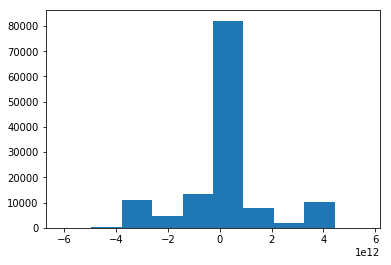

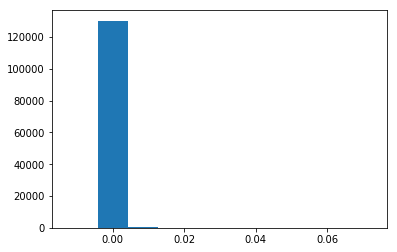

In [24]:
plt.hist(ols.coef_[0])
plt.show()

plt.hist(rdg.coef_[0])
plt.show()

### MODEL: Decision Tree Classifier

In [23]:
from sklearn import tree
dtc = tree.DecisionTreeClassifier(max_depth=100)
dtc.fit(X_matrix, y)
joblib.dump(dtc, 'dtc.pkl') # pickle

dtc_performance = BinaryClassificationPerformance(dtc.predict(X_matrix), y, 'dtc')
dtc_performance.compute_measures()
print(dtc_performance.performance_measures)

{'Pos': 26572, 'Neg': 337428, 'TP': 10575, 'TN': 337396, 'FP': 32, 'FN': 15997, 'Accuracy': 0.9559642857142857, 'Precision': 0.9969831243518431, 'Recall': 0.397975312358874, 'desc': 'dtc'}


### ROC plot to compare performance of various models and fits

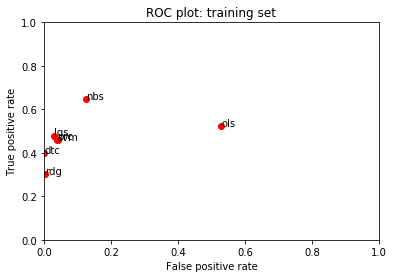

In [25]:
fits = [svm_performance, lgs_performance, rdg_performance, prc_performance, ols_performance, dtc_performance, nbs_performance]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'ro')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: training set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

## a digression: looking inside the `rdg` object

[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html)

In [26]:
dir(rdg)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_decision_function',
 '_estimator_type',
 '_get_param_names',
 '_label_binarizer',
 '_predict_proba_lr',
 '_preprocess_data',
 '_set_intercept',
 'alpha',
 'class_weight',
 'classes_',
 'coef_',
 'copy_X',
 'decision_function',
 'fit',
 'fit_intercept',
 'get_params',
 'intercept_',
 'max_iter',
 'n_iter_',
 'normalize',
 'predict',
 'random_state',
 'score',
 'set_params',
 'solver',
 'tol']

In [27]:
rdg.get_params()

{'alpha': 5.0,
 'class_weight': None,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [28]:
type(rdg.coef_)

numpy.ndarray

In [29]:
rdg.coef_.shape

(1, 131074)

In [30]:
print(rdg.coef_[0])

[-0.00070527  0.          0.         ...  0.00012135  0.00029041
  0.07247437]


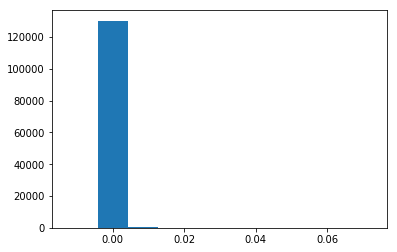

In [31]:
plt.hist(rdg.coef_[0])
plt.show()

# looking at reviews based on their classification

Let's say we decide that Ridge Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [32]:
amazon.loc[0, "Text"]

"I really like this product!  I first read about it in my Diabetic Living magazine and since I love peanut butter, wanted to give it a try.  While it will never replace the real thing, it had a really good roasted peanut flavor and a smooth, creamy texture.  I ate it smeared over two Corn Thin cakes, with 1/2 tbsp of reduced sugar jam and it was really satisfying, all for 104 calories! I probably won't eat this by the spoonful, like I love to do with peanut butter, but it will be great in sandwiches or with apples as a healthy snack.  I am very satisfied with the taste and texture of this peanut butter.  Yay!"

In [33]:
amazon.loc[0, "helpful"]

False

In [34]:
ridge_predictions = rdg.predict(X)

In [35]:
ridge_predictions.shape

(364000,)

In [36]:
print(ridge_predictions)

[False False False ... False False False]


In [37]:
# false positives

import random, time

for i in range(0, len(ridge_predictions)):
    if (ridge_predictions[i] == True):
        if (amazon.loc[i, "helpful"] == False):
            if (random.uniform(0, 1) < 0.05):
                print(i)
                print(time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(amazon.loc[i, "Time"])))
                print(amazon.loc[i, "Score"])
                print(amazon.loc[i, "HelpfulnessDenominator"])
                print(amazon.loc[i, "ProductId"])
                print(amazon.loc[i, "Text"])
                print('* * * * * * * * * ')

9374
2012-10-08 00:00:00
5
0
B0043V5SN6
This Ocean Spray jellied cranberry sauce is an excellent product. I serve it with meat and fish. A great side dish. Get the largest size pack from Amazon cause it goes fast.
* * * * * * * * * 
12405
2012-06-06 00:00:00
3
0
B004VDGX1W
too many stems, not enough leaf/flowers. makes a decent brew at 2 tblsp per cup, but still, what is up with having so many stems that is just so weird
* * * * * * * * * 
42289
2011-10-16 00:00:00
4
2
B004391DK0
Ok--I just bought BIsquick GF and the first thing I tried to make were the drop biscuits (recipe listed on the box).  These are not the kind that are rolled out & cut--these are "drop "biscuits.  The results were very tasty.  The taste of this GF bisquick is very much like the original, but the taste is not as tart as the original.  If you want a similar buttermilk taste, you will need to use buttermilk instead of milk in the biscuit recipe.  I noticed something else that was odd and might be a problem for any

225538
2011-01-02 00:00:00
4
2
B002B95HAG
This product works as described.  It is easy to use once you get the hang of it.  Users will need to develop a system for pausing the stuffing in order to refill the tube.  I am on my third batch of sausages using this sausage gun, and the only minor complaint I have is a bit of liquid leaking out during the stuffing process.  Overall very happy especially considering the price.
* * * * * * * * * 
253726
2012-07-18 00:00:00
5
0
B001IZBORY
I can't believe I have been eating store bought pasta all these years, I just didn't know any better.  The first time I tasted La Campofilone pappardelle, I was hooked. The taste and texture of this pasta is beyond compare. I have not bought store pasta since and will never buy from a grocery store again.<br />THE BEST PASTA EVER!
* * * * * * * * * 
282033
2011-08-24 00:00:00
5
0
B000LBNUUU
I'm a spice addict, I admit it.  I keep 3 types of hot spices at work and poor hot sauce or hot pepper powder in my coffe